## Clustering Algorithms

Machine learning is one domain that can frequently take advantage of vectorization and broadcasting. Let’s say that you have the vertices of a triangle (each row is an x, y coordinate):

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [3]:
tri = np.array([[1, 1],
                [3, 1],
                [2, 3]])

The centroid of this “cluster” is an (x, y) coordinate that is the arithmetic mean of each column:

In [6]:
centroid = tri.mean(axis=0)
centroid

array([2.        , 1.66666667])

It’s helpful to visualize this:

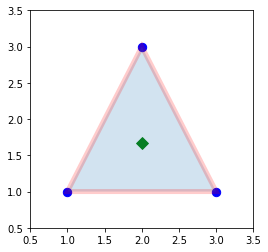

In [9]:
trishape = plt.Polygon(tri, edgecolor='r', alpha=0.2, lw=5)
_, ax = plt.subplots(figsize=(4, 4))
ax.add_patch(trishape)
ax.set_ylim([.5, 3.5])
ax.set_xlim([.5, 3.5])
ax.scatter(*centroid, color='g', marker='D', s=70)
ax.scatter(*tri.T, color='b',  s=70)

Many clustering algorithms make use of Euclidean distances of a collection of points, either to the origin or relative to their centroids.

In Cartesian coordinates, the Euclidean distance between points p and q is:

In [10]:
np.sum(tri**2, axis=1) ** 0.5  # Or: np.sqrt(np.sum(np.square(tri), 1))

array([1.41421356, 3.16227766, 3.60555128])

You may recognize that we are really just finding Euclidean norms:

In [11]:
np.linalg.norm(tri, axis=1)

array([1.41421356, 3.16227766, 3.60555128])

Instead of referencing the origin, you could also find the norm of each point relative to the triangle’s centroid:

In [12]:
np.linalg.norm(tri - centroid, axis=1)

array([1.20185043, 1.20185043, 1.33333333])

Finally, let’s take this one step further: let’s say that you have a 2d array X and a 2d array of multiple (x, y) “proposed” centroids. Algorithms such as K-Means clustering work by randomly assigning initial “proposed” centroids, then reassigning each data point to its closest centroid. From there, new centroids are computed, with the algorithm converging on a solution once the re-generated labels (an encoding of the centroids) are unchanged between iterations. A part of this iterative process requires computing the Euclidean distance of each point from each centroid:

In [21]:
X = np.repeat([[5, 5], [10, 10]], [5, 5], axis=0)
X = X + np.random.randn(*X.shape)  # 2 distinct "blobs"
centroids = np.array([[5, 5], [10, 10]])

array([[ 6.90847063,  3.8849303 ],
       [ 5.81491193,  4.9580814 ],
       [ 3.95192498,  6.49013654],
       [ 4.04101059,  4.0477441 ],
       [ 3.76231672,  6.30396811],
       [ 9.02023574,  8.54388763],
       [ 8.77029031, 10.13000184],
       [ 8.27481072, 11.11546284],
       [11.79403853,  9.12170824],
       [ 9.0018497 , 10.02683446]])

In [34]:
X

array([[ 6.90847063,  3.8849303 ],
       [ 5.81491193,  4.9580814 ],
       [ 3.95192498,  6.49013654],
       [ 4.04101059,  4.0477441 ],
       [ 3.76231672,  6.30396811],
       [ 9.02023574,  8.54388763],
       [ 8.77029031, 10.13000184],
       [ 8.27481072, 11.11546284],
       [11.79403853,  9.12170824],
       [ 9.0018497 , 10.02683446]])

In [22]:
centroids

array([[ 5,  5],
       [10, 10]])

In other words, we want to answer the question, to which centroid does each point within X belong? We need to do some reshaping to enable broadcasting here, in order to calculate the Euclidean distance between each point in X and each point in centroids:

In [39]:
X.shape

(10, 2)

In [40]:
centroids.shape

(2, 2)

In [41]:
centroids[:, None]

array([[[ 5,  5]],

       [[10, 10]]])

In [42]:
centroids[:, None].shape

(2, 1, 2)

This enables us to cleanly subtract one array from another using a combinatoric product of their rows:

In [53]:
distance = np.linalg.norm(X - centroids[:, None], axis=2).round(2)
distance

array([[2.21, 0.82, 1.82, 1.35, 1.8 , 5.36, 6.37, 6.94, 7.95, 6.43],
       [6.85, 6.55, 6.99, 8.42, 7.25, 1.76, 1.24, 2.05, 2.  , 1.  ]])

In [47]:
distance.shape

(2, 10)

In other words, the shape of X - centroids[:, None] is (2, 10, 2), essentially representing two stacked arrays that are each the size of X.

Next, we want the label (index number) of each closest centroid, finding the minimum distance on the 0th axis from the array above:

In [54]:
np.argmin(np.linalg.norm(X - centroids[:, None], axis=2), axis=0)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

numpy.argmin(a, axis=None, out=None) — Returns the indices of the minimum values along an axis.

You can put all this together in functional form:

In [56]:
def get_labels(X, centroids) -> np.ndarray:
    return np.argmin(np.linalg.norm(X - centroids[:, None], axis=2),axis=0)

labels = get_labels(X, centroids)

In [62]:
labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

Let’s inspect this visually, plotting both the two clusters and their assigned labels with a color-mapping:

Text(0.5, 1.0, 'One K-Means Iteration: Predicted Classes')

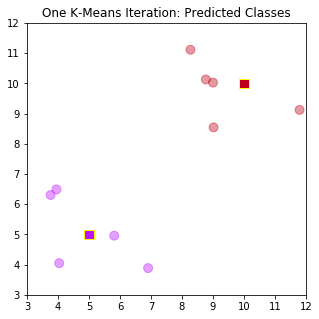

In [59]:
c1, c2 = ['#bc13fe', '#be0119']  # https://xkcd.com/color/rgb/
llim, ulim  = np.trunc([X.min() * 0.9, X.max() * 1.1])

_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*X.T, c=np.where(labels, c2, c1), alpha=0.4, s=80)
ax.scatter(*centroids.T, c=[c1, c2], marker='s', s=95, edgecolor='yellow')
ax.set_ylim([llim, ulim])
ax.set_xlim([llim, ulim])
ax.set_title('One K-Means Iteration: Predicted Classes')